# 2D Ornstein Uhlenbeck Type System Instanton Calculation via MAM

In this notebook we will use the MAM method outlined in [1] to calculate an instanton in a 2D OU type model. We will compare this to the analytic solution as well as the numerically integrated Hamilton Equations.

- [1] Weinan, E., Ren, W. and Vanden-Eijnden, E., 2004. Minimum action method for the study of rare events. Communications on pure and applied mathematics, 57(5), pp.637-656.

In [1]:
# Standard Package imports

import numpy as np
import numpy.linalg as la
import numpy.random as rm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# MAM Algorithm
from mam import Mam_alg

# Problem Definition & Parameter Choices

Here we define the drift function of the 2D OU system and specify our parameter choices.

In [2]:
# Drift Function Definition

def a(t, phi, s):
    """Drift term"""
    gamma1, gamma2, r = s
    x, T = phi.T
    return np.array([- gamma1 * (x + T), -gamma2 * (T - x)]).T

In [3]:
# Parameter Specification

# OU Parameters
gamma1 = 0.5
gamma2 = 0.25
r = 0.1
s = [gamma1, gamma2, r]

# Covariance matrix
sigma1 = 0.001
sigma2 = 0.002
D = np.zeros((2, 2))
D[0, 0] = sigma1**2
D[1, 1] = sigma2**2
Dinv = la.inv(D)

# Time
t0 = 0
tF = 10
dt = 0.1
steps = int((tF-t0)/dt)
time = np.arange(t0, tF, dt)

## MAM Set up

Here we define the initial instanton path for the minimisation problem, specify bounds and create a MAM algorithm object.

In [26]:
# Instanton Initialisation

initial_point = [0.1, 0]
final_point = [1, 0.5]

inst_ic = np.linspace(initial_point, final_point, steps)

In [27]:
# 
# Example Bounds Grid - Useful should you want to specify your own bounds
# -------------------
# 

bnds = np.zeros((*inst_ic.shape, 2)) # indexed by Time, ndim, lower/upper

# t = 0 Constraint
bnds[0,...,0] = initial_point - 0.01 * np.ones(inst_ic.shape[1]) # Lower
bnds[0,...,1] = initial_point + 0.01 * np.ones(inst_ic.shape[1]) # Upper

# Bounds for t \in (dt, T-dt)
bnds[1:-1, ..., 0] = - 1
bnds[1:-1, ..., 1] = 1

# t = T Constraint
bnds[-1,...,0] = final_point - 0.01 * np.ones(inst_ic.shape[1])
bnds[-1,...,1] = final_point + 0.01 * np.ones(inst_ic.shape[1])

In [28]:
# Object creation

# ou_mam = Mam_alg(a, s, inst_ic, time, Dinv) # default bounds
ou_mam = Mam_alg(a, s, inst_ic, time, Dinv, bnds=bnds) # specify bounds 

## Running MAM Algorithm

We run the algorithm for 80000 iterations/until convergence.

In [29]:
# Running for an initial 30000 Steps
options={'maxls': 10, 'maxiter': 30000, 'maxfun': 30000} 

In [ ]:
result = ou_mam.run(options)

In [ ]:
# Running algorithm for a further 40000 steps
options={'maxls': 10, 'maxiter': 40000, 'maxfun': 40000}
result = ou_mam.run(options) 
print(f'Algorithm has made {ou_mam.nfev} function evaluations')

## Comparison With Analytic Solution

We plot the MAM output alongside the known analytic solution.

In [10]:
# NEED TO DEFINE ANALYTIC SOLUTION FOR BOUNDARY VALUE PROBLEM

# def analytic_solution(time, x0, xf, s):
#     gamma, sigma = s
#     t0 = time[0]
#     tf = time[-1]
#     c1 = (xf - x0 * np.exp(- gamma * tf))/(2 * np.sinh(gamma * tf))
#     c2 = x0 - c1
#     return c1 * np.exp(gamma * time) + c2 * np.exp(-gamma * time)

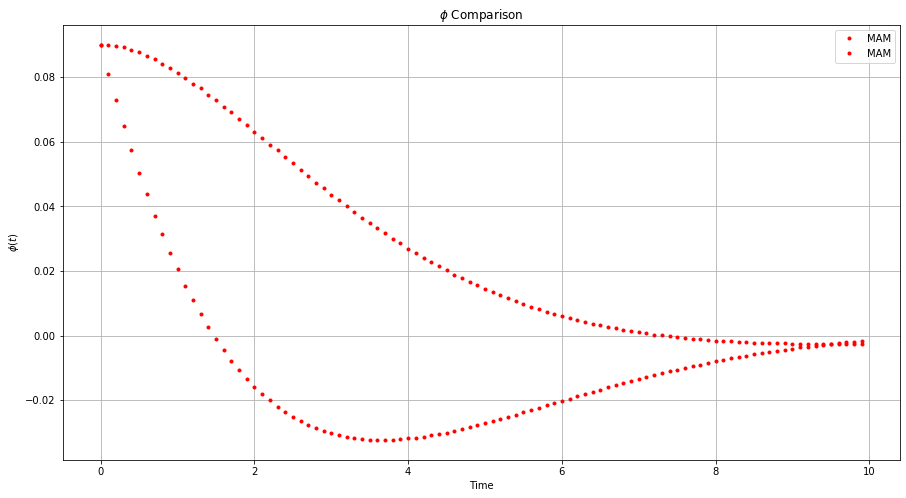

In [11]:
# Comparison Plot

fig, ax = plt.subplots(figsize=(15, 8))

ax.grid()
ax.set_title('$\\phi$ Comparison')
# ax.plot(time,  analytic_solution(time, initial_point, final_point, s),'b', linewidth=2, label = 'Analytic')
ax.plot(time, ou_mam.instanton, 'r.', label = 'MAM')
ax.set_xlabel('Time')
ax.set_ylabel('$\\phi(t)$')
ax.legend()
fig.show()

## Calculating action For Nearby Paths

We compare the action for slightly perturb paths, create a histogram and check if our found path does indeed minimise.

In [ ]:
from instanton_utility import *

In [ ]:
# Creating A Load Of Random Paths to compare against

# near_paths = [random_path(ou_mam.instanton, 0.01) for i in range(10000)] # Conclusion Different depending on paths
near_paths = [random_path(ou_mam.instanton, 0.001) for i in range(10000)]

In [ ]:
# Creating Object to Track Action Check

action_track = action_minimisation_checker(a, ou_mam.instanton, [s, time, Dinv])

In [ ]:
# Doing the Comparison

for path in near_paths:
    action_track.compare(path)

In [ ]:
# Histogram 

fig, ax = plt.subplots(figsize=(15, 8))

ax.grid()
ax.hist(action_track.av_list, bins=100, density=True)
ax.plot(np.full_like(np.linspace(0, 1), action_track.action_value), np.linspace(0, 1), '--o', label='MAM Instanton')
ax.set_xlabel('Action Value')
ax.set_ylabel('$\\rho$')
ax.set_title('Action Density For Nearby Paths')
ax.legend()
fig.show()

In [ ]:
plt.plot(near_paths[1])